In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import math
from kitegrid import KiteGrid, draw_kite_grid, draw_hat
from pysat.formula import CNF, IDPool
from pysat.solvers import Solver
import json
import pickle
from itertools import combinations
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import unary_union

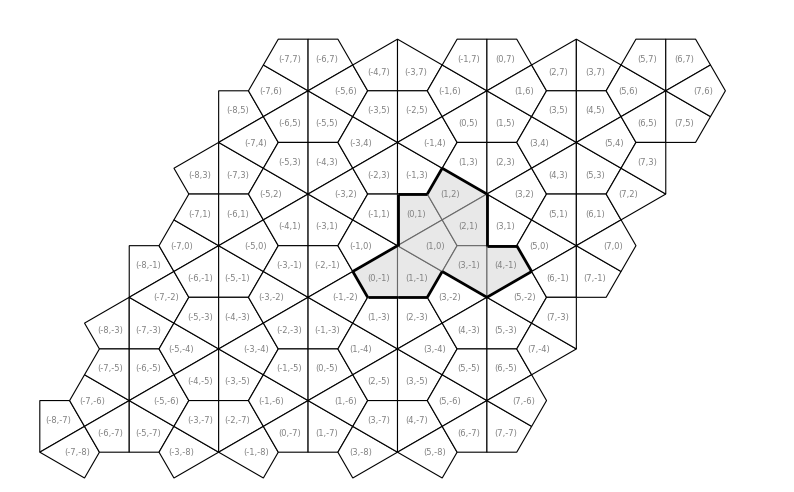

In [2]:
# origin hat
hat = [(1,0),(0,1),(1,-1),(0,-1),(1,2),(2,1),(3,-1),(4,-1)]

plt.ioff()
fig, ax = draw_kite_grid(8,8,True)
draw_hat(ax,hat)
plt.show()


In [3]:
# rotation matrix
R = np.array([[0, -1],[1, 1]])

# reflection matrix
P = np.array([[1, 1], [0, -1]])

In [4]:
def rotate_hat(S):
    """Rotates shape S (hat) by 60 degrees counterclockwise"""
    Sr = []
    for p in S:
        Sr.append(tuple(R@np.array(p).T))
    return Sr

def reflect_hat(S):
    """Reflects shape S (hat) over v=(1,0)"""
    Sr = []
    for p in S:
        Sr.append(tuple(P@np.array(p).T))
    return Sr

In [5]:
def generate_transformations(hat, k, include_reflections=True):
    """
    Generate all valid transformations (rotations, reflections, translations)
    of the hat that might appear in the k-th corona.
    A valid k-corona hat:
        - is adjacent to at least one (k-1)-corona hat
    """
    V1 = np.array(KiteGrid.translationV1)
    V2 = np.array(KiteGrid.translationV2)

    # --- Helper functions ---
    def intersects(A, B):
        """Return True if two hats share any cell."""
        return not set(A).isdisjoint(B)

    # The 0-corona is just the seed hat (no transformations)
    T0 = [(hat, {'rotation': 0, 'reflection': False, 'translation': (0, 0), 'm': 0, 'n': 0})]
    if k == 0:
        return T0

    # Store all coronas progressively
    all_coronas = {0: T0}

    # Grow coronas one by one up to k
    for i in range(1, k + 1):
        prev_corona = all_coronas[i - 1]
        inner_coronas = [S for t in range(0, i - 1) for (S, _) in all_coronas[t]]
        T_k = []

        # Try all rotations and reflections
        for rot in range(6):  # 6 possible 60° rotations
            rotated_hat = hat
            for _ in range(rot):
                rotated_hat = rotate_hat(rotated_hat)

            for reflected in ([False, True] if include_reflections else [False]): # reflect or not
                shape = reflect_hat(rotated_hat) if reflected else rotated_hat

                # Lattice translations: limit expands with corona index
                limit = i
                for m in range(-3*limit - 1, 3*limit + 1):
                    for n in range(-3*limit - 1,3*limit + 1): 
                        t = m * V1 + n * V2                        
                        dx, dy = int(t[0]), int(t[1])
                        translated_hat = [(x + dx, y + dy) for (x, y) in shape]

                        # Skip invalid tiles (orientation 7 = not a kite)
                        if any(KiteGrid.get_tile_orientation(p) == 7 for p in translated_hat):
                            continue

                        adjacent_to_prev = any(
                            KiteGrid.adjacent(translated_hat, S)
                            for S, _ in prev_corona
                        )

                        # adjacent_to_inner = any(
                        #     KiteGrid.adjacent(translated_hat, S)
                        #     for S in inner_coronas
                        # )

                        # overlaps_inner = any(
                        #     intersects(translated_hat, S)
                        #     for S in inner_coronas
                        # )

                        # Only keep outer, valid placements
                        if adjacent_to_prev: #and not overlaps_inner and not adjacent_to_inner:
                            T_k.append((
                                translated_hat,
                                {
                                    'rotation': rot,
                                    'reflection': reflected,
                                    'translation': (dx, dy),
                                    'm': m,
                                    'n': n
                                }
                            ))

        all_coronas[i] = T_k

    return all_coronas[k]


In [6]:
def kites_to_hat(kites):
    """Given a list of kites that represent the hat it returns the hat as an ordered list of its edges (independent from kites)"""

    def edge_key(a, b):
        """Return a canonical representation of an edge (unordered pair)."""
        return tuple(sorted([a, b]))

    edges = {}
        
    # Step 1: Collect edges of all hat kites
    for p in kites:
        vertices = KiteGrid.get_cell_vertices(p)
        cart_vertices = [KiteGrid.grid_to_cartesian(v) for v in vertices]
        
        # Make sure the polygon is closed
        cart_vertices.append(cart_vertices[0])
        for c, d in zip(cart_vertices[:-1], cart_vertices[1:]):
            key = edge_key(c, d)
            edges[key] = edges.get(key, 0) + 1
    
    # Step 2: Keep only boundary edges (appear once)
    boundary_edges = [edge for edge, count in edges.items() if count == 1]

    ordered = [boundary_edges[0][0], boundary_edges[0][1]]
    edges_left = boundary_edges[1:]

    while edges_left:
        last = ordered[-1]
        found = False
        for i, (a, b) in enumerate(edges_left):
            if a == last:
                ordered.append(b)
                edges_left.pop(i)
                found = True
                break
            elif b == last:
                ordered.append(a)
                edges_left.pop(i)
                found = True
                break
        if not found:
            break
    return ordered

In [7]:
# Example usage of generate_transformations for 2 coronas around the origin hat

transforms = generate_transformations(hat, k=2, include_reflections=True)
print(f"Generated {len(transforms)} valid transformations")

# Preview the first few
for shape, info in transforms[:5]:
    print(info, "→ first 3 tiles:", shape[:3])

Generated 426 valid transformations
{'rotation': 0, 'reflection': False, 'translation': (-12, 6), 'm': -3, 'n': 0} → first 3 tiles: [(-11, 6), (-12, 7), (-11, 5)]
{'rotation': 0, 'reflection': False, 'translation': (-10, 8), 'm': -3, 'n': 1} → first 3 tiles: [(-9, 8), (-10, 9), (-9, 7)]
{'rotation': 0, 'reflection': False, 'translation': (-8, 10), 'm': -3, 'n': 2} → first 3 tiles: [(-7, 10), (-8, 11), (-7, 9)]
{'rotation': 0, 'reflection': False, 'translation': (-12, 0), 'm': -2, 'n': -2} → first 3 tiles: [(-11, 0), (-12, 1), (-11, -1)]
{'rotation': 0, 'reflection': False, 'translation': (-10, 2), 'm': -2, 'n': -1} → first 3 tiles: [(-9, 2), (-10, 3), (-9, 1)]


To use a SAT solver for getting a tessellation, we define the variables s_{T,k} for each possible transformation and c_{i,j} for each possible cell of the grid.

In [8]:
# Create all variables that will be used in the CNF formula

# number of coronas
n = 2

pool = IDPool()
placements = {}

all_transforms = {}

j = 0
for i in range(n+1):
    if i == 2:
        include_reflections = False # disallow reflections in the outermost corona
    else:
        include_reflections = True
    valid_transformations = generate_transformations(hat, i, include_reflections=include_reflections)
    all_transforms[i] = valid_transformations

    # generate a unique id for each transformation(shape)
 
    for idx, (_, info) in enumerate(valid_transformations):
        placements[(i, idx)] = pool.id(f"S_({info['rotation']}_{info['reflection']}_{info['translation']})_{i}") # index i defines the corona

all_transforms_list = [t for v in all_transforms.values() for t in v]


In [9]:
# generate a unique id for each cell
cells = {}

for hat, _ in all_transforms_list:
    for cell in hat:
        if cell not in cells.keys():
            cells[cell] = pool.id(f'c_{cell}')

In [10]:
# auxiliary function to check if two hats are simply connected (no holes)

def simply_connected(S1, S2):
    """Check if the union of two hats (lists of kite grid cells) is simply connected."""

    S1 = kites_to_hat(S1)
    S2 = kites_to_hat(S2)
    
    p1 = ShapelyPolygon(S1)
    p2 = ShapelyPolygon(S2)
    u = unary_union([p1, p2])
    return u.is_valid and not u.interiors  # no holes → simply connected

In [11]:
def cnf(placements, cells, all_transforms):
    """Take the list of variables to be used in the cnf and the list of all transformations and return the solution of the cnf if one exists"""
    cnf = CNF()

    # 0-corona is always used
    cnf.append([placements[(0,0)]])

    # If a copy of S is used, then its cells are used
    for k, hats in all_transforms.items():
        for idx, hat in enumerate(hats):
            for cell in hat[0]:
                cnf.append([-placements[(k,idx)], cells[cell]])

    # dictionary of which hats cover a given cell
    cell_to_hats = {}
    for k, hats in all_transforms.items():
        for idx, hat in enumerate(hats):
            for cell in hat[0]:
                cell_to_hats.setdefault(cell, []).append((k,idx))

    # If a cell is used, then some copy of S must use it
    for cell, hats in cell_to_hats.items():
        c_var = cells[cell]
        hat_vars = [placements[i] for i in hats]
        cnf.append([-c_var] + hat_vars)

    # If a copy of S is used in an interior corona (a k-corona for k < n), then that copy’s halo cells must be used.
    for k in range(n):  # interior coronas only
        for i, (hat, _) in enumerate(all_transforms[k]):
            h_var = placements[(k,i)]

            # Compute halo cells for this hat placement
            halo_cells = KiteGrid.halo(hat)

            for cell in halo_cells:
                # Skip if cell not part of any defined region
                if cell not in cells:
                    continue

                c_var = cells[cell]
                cnf.append([-h_var, c_var])  # if hat is active, halo cell must be active

    # Used copies of S cannot overlap.
    for cell, hats in cell_to_hats.items():
        for a, b in combinations(hats, 2):
            cnf.append([-placements[a], -placements[b]])

    # If a copy of S is used in a k-corona, it must be adjacent to a copy in a (k−1)-corona.
    for k in range(1, n + 1):
        for i, (hat,_) in enumerate(all_transforms[k]):
            h_var = placements[(k,i)]
            prev_vars = []
            for j, (hat_min_1,_) in enumerate(all_transforms[k-1]):
                h_min_1_var = placements[(k-1,j)]
                if KiteGrid.adjacent(hat, hat_min_1):
                    prev_vars.append(h_min_1_var)
            if prev_vars:
                cnf.append([-h_var] + prev_vars)        
            else:
                cnf.append([-h_var])


    # If a copy of S is used in a k-corona, it cannot be adjacent to a copy in an m-corona for m < k−1.
    for k in range(2, n + 1):
        for i, (hat,_) in enumerate(all_transforms[k]):
            h_var = placements[(k,i)]
            for l in range(k-1):
                for j, (hat_min_1,_) in enumerate(all_transforms[l]):
                    h_min_1_var = placements[(l,j)]
                    if KiteGrid.adjacent(hat, hat_min_1):
                        cnf.append([-h_var,-h_min_1_var])

    # suppress holes in the outermost corona
    for i, (hat1,_) in enumerate(all_transforms[n]):
        for j, (hat2,_) in enumerate(all_transforms[n]):
            if KiteGrid.edge_adjacent(hat1,hat2):
                if not simply_connected(hat1, hat2):
                    cnf.append([-placements[(n,i)],-placements[(n,j)]])

    return cnf

In [12]:
cnf = cnf(placements, cells, all_transforms)

In [ ]:
with Solver(bootstrap_with=cnf) as solver:
    if solver.solve():
        model = solver.get_model()
        active = [idx for idx,var in placements.items() if var in model] # save the placements that are used in the tiling
        print("Satisfiable, active placements:", len(active))
    else:
        print("Unsatisfiable")

Satisfiable, active placements: 19


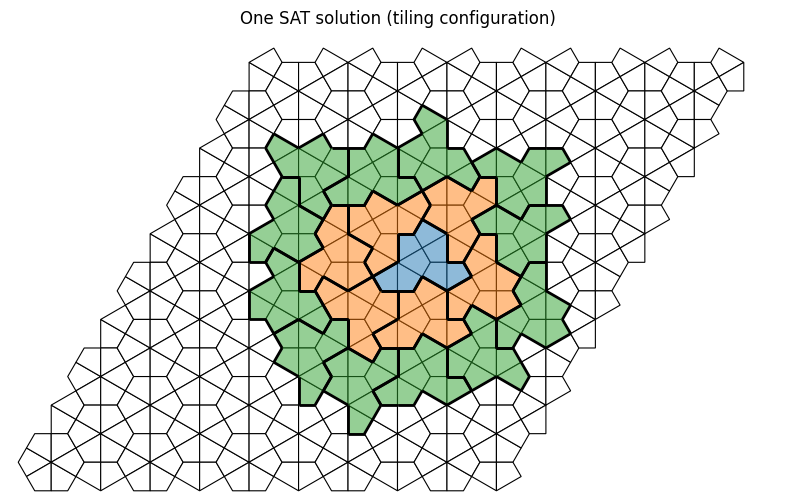

In [14]:
# Draw one solution

fig, ax = draw_kite_grid(15, 15, show_labels=False)

# Color palette for coronas
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Draw each active hat
for corona, idx in active:
    shape, _ = all_transforms[corona][idx]
    color = colours[corona % len(colours)]
    draw_hat(ax, shape, color)

plt.title("One SAT solution (tiling configuration)")
plt.show()

In [15]:
# get 1000 different solutions (if they exist)

solutions = []
max_solutions = 1000

with Solver(bootstrap_with=cnf) as solver:
    while solver.solve():
        model = solver.get_model()
        solutions.append(model)
        # Add blocking clause to exclude this model
        solver.add_clause([-lit for lit in model])
        if len(solutions) > max_solutions:
            break

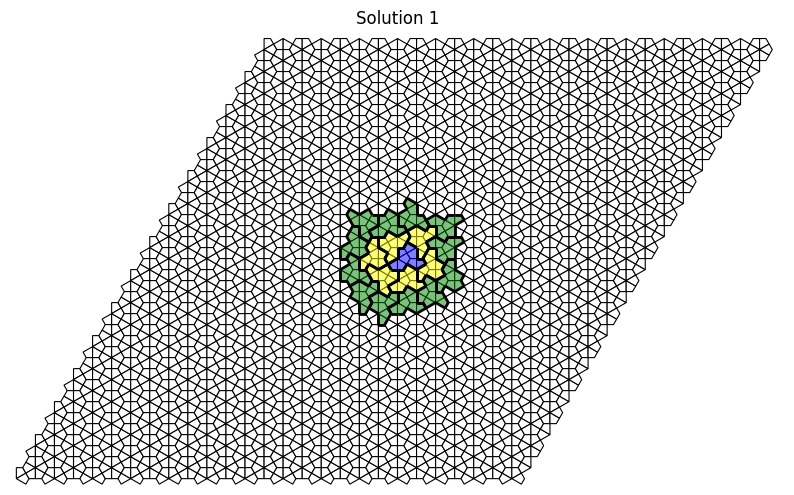

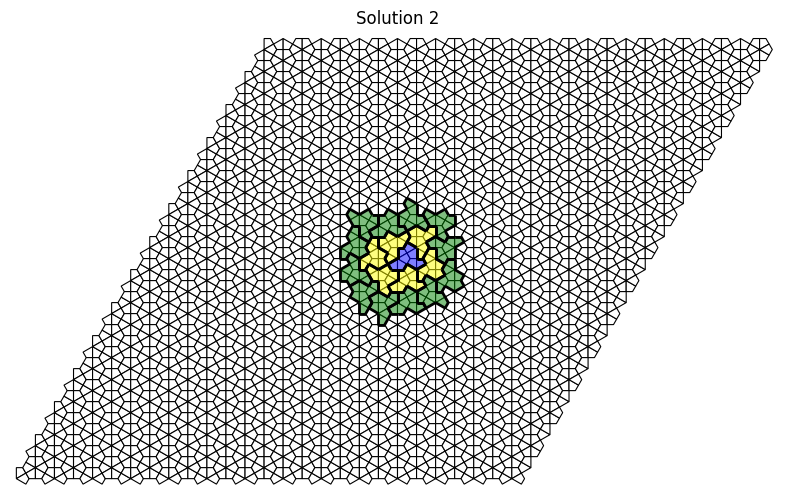

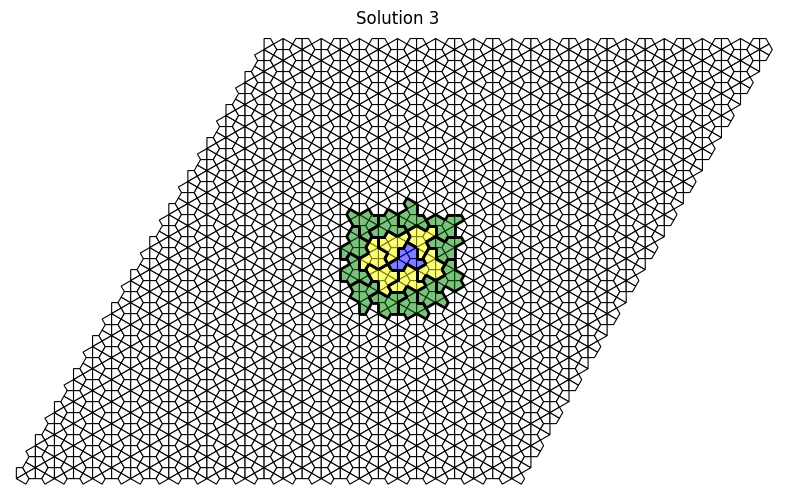

In [ ]:
# Draw 3 different solutions

colours = ['blue', 'yellow', 'green']

for sol_idx, model in enumerate(solutions[:3]):
    # Find which placements are active in this model
    act = [(corona, idx) for (corona, idx), var in placements.items() if var in model]

    # Create a new figure for this solution
    fig, ax = draw_kite_grid(40, 40, show_labels=False)
    
    # Draw all active hats for this solution
    for corona, idx in act:
        shape, _ = all_transforms[corona][idx]
        color = colours[corona % len(colours)]
        draw_hat(ax, shape, color)
    
    plt.title(f"Solution {sol_idx + 1}")
    plt.show()

### Save the model and other necessary data structures for 6 coronas

In [ ]:
# save the cnf for 6 coronas
with open("6corona_model/cnf.pkl", "wb") as f:
    pickle.dump(cnf, f, protocol=pickle.HIGHEST_PROTOCOL)

# save the transformations for 6 coronas
with open("tiling_data.pkl", "wb") as f:
    pickle.dump(all_transforms, f, protocol=pickle.HIGHEST_PROTOCOL)

# save the placements for 6 coronas
with open("placements.pkl", "wb") as f:
    pickle.dump(placements, f, protocol=pickle.HIGHEST_PROTOCOL)

# save the celss for 6 coronas
with open("cells.pkl", "wb") as f:
    pickle.dump(cells, f, protocol=pickle.HIGHEST_PROTOCOL)

# save the model for 6 coronas
with open("model6corona.pkl", "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

Open the saved model and the cnf with 6 coronas (forgot to save the cells so i need to define placements and cells again)

In [18]:
with open("6corona_model/tiling_data.pkl", "rb") as f:
    all_transforms6 = pickle.load(f)

with open("6corona_model/cnf.pkl", "rb") as f:
    cnf6 = pickle.load(f)

# Define all variables that will be used in the CNF formula from the saved tranfsormations of 6 coronas

# number of coronas
n = 6

pool = IDPool()
placements6 = {}

j = 0
for i in range(n+1):
    valid_transformations = all_transforms6[i]

    # generate a unique id for each transformation(shape)
 
    for idx, (_, info) in enumerate(valid_transformations):
        placements6[(i, idx)] = pool.id(f"S_({info['rotation']}_{info['reflection']}_{info['translation']})_{i}") # index i defines the corona

all_transforms_list6 = [t for v in all_transforms6.values() for t in v]

cells6 = {}

for hat, _ in all_transforms_list6:
    for cell in hat:
        if cell not in cells6.keys():
            cells6[cell] = pool.id(f'c_{cell}')

# Transforming hat to Tile(a,b)

In [19]:
def rotate_list(lst, start_index):
    return lst[start_index:] + lst[:start_index]

In [20]:
def tile_ab(vertices,starting_index,starting_vertex,desired_short = 1,desired_long = math.sqrt(3)):
    """Transform the vertices of a hat into vertices of an arbitrary Tile(a,b)"""

    # Compute edge lengths and angles
    edges = []
    angles = []
    for i in range(len(vertices)-1):
        x0, y0 = vertices[i]
        x1, y1 = vertices[i+1]
        dx = x1 - x0
        dy = y1 - y0
        length = math.sqrt(dx**2 + dy**2)
        angle = math.atan2(dy, dx)
        edges.append(length)
        angles.append(angle)

    # Identify short and long edges
    short_edge = min(edges)
    long_edge = max(edges)

    # Determine new edges based on original sequence
    new_edges = [desired_short if math.isclose(l, short_edge) else desired_long for l in edges]

    if starting_index != None:
        new_edges = rotate_list(new_edges, starting_index)
        angles = rotate_list(angles, starting_index)

    # Reconstruct polygon
    new_vertices = [starting_vertex if starting_index is not None else vertices[0]]
    for length, angle in zip(new_edges[:-1], angles[:-1]):
        x_prev, y_prev = new_vertices[-1]
        x_new = x_prev + length * math.cos(angle)
        y_new = y_prev + length * math.sin(angle)
        new_vertices.append((x_new, y_new))
    if starting_index is not None:
        new_vertices = rotate_list(new_vertices,len(new_vertices) - starting_index)
        new_vertices.append(new_vertices[0])
        return new_vertices
    else:
        new_vertices.append(starting_vertex if starting_index is not None else vertices[0])
        return new_vertices

In [21]:
# draw a tile defined by its vertices
from matplotlib.colors import to_rgba

def draw_tile(ax,tile,colour='lightgrey'):
    
    poly = Polygon(tile, closed=True, facecolor=to_rgba(colour, 0.5),edgecolor='black', lw=1)
    ax.add_patch(poly)

In [22]:
# transform kite representations into edge representations
tiling = {}
for corona, idx in active:
    shape, _ = all_transforms[corona][idx]
    tiling.setdefault(corona, []).append(kites_to_hat(shape))

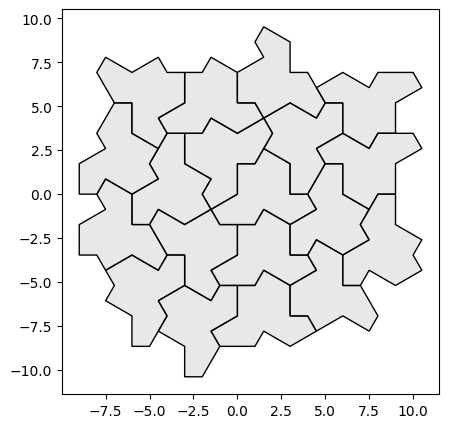

In [23]:
# example of a hat tiling

fig,ax = plt.subplots(figsize=(5, 5))
for hats in tiling.values():
    for hat in hats:
        draw_tile(ax,hat)
ax.set_aspect('equal', 'box')
ax.autoscale_view()
# ax.axis('off')
plt.show()

In [24]:
def get_starting_index(hat, corona, tiling, tol=1e-6):
    """Given a hat (as list of vertices) in a given corona, find the index of a vertex that touches a hat in the previous corona."""
    if corona == 0:
        return None,None,None  # first corona has no previous one
    
    prev_corona = tiling[corona - 1]
    
    for i, v in enumerate(hat):
        vx, vy = v
        for prev_j,prev_hat in enumerate(prev_corona):
            for idx_prev,u in enumerate(prev_hat):
                if np.hypot(vx - u[0], vy - u[1]) < tol:
                    return i,prev_j,idx_prev
    return None,None,None


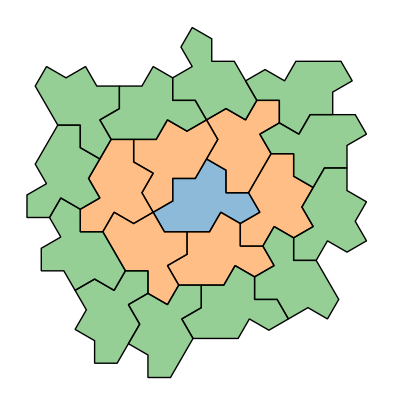

In [164]:
# Draw an entire tiling with an arbitrary Tile(a,b)

fig,ax = plt.subplots(figsize=(5, 5))
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
tiling_with_tiles = {}
for corona, hats in tiling.items():
    colour = colours[corona % len(colours)]
    for i,hat in enumerate(hats):
        starting_index,prev_j,idx_prev = get_starting_index(hat,corona,tiling)
        if corona >= 1:
            starting_vertex = tiling_with_tiles[corona-1][prev_j][idx_prev]
        else:
            starting_vertex = hat[0]
        tile = tile_ab(hat,starting_index,starting_vertex,1,1)
        if corona==0:
            tile11 = tile
        tiling_with_tiles.setdefault(corona,[]).append(tile)
        draw_tile(ax,tile,colour=colour)
ax.set_aspect('equal', 'box')
ax.autoscale_view()
ax.axis('off')
plt.savefig("tiling.pdf", format="pdf", bbox_inches="tight")
plt.show()

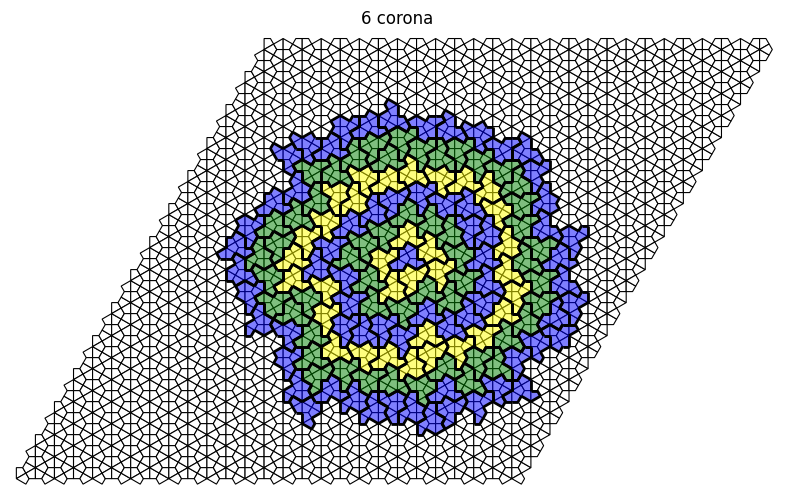

In [ ]:
# Load a saved model with 6 coronas taken from a model with 7 coronas

# Load the saved model
with open("7corona.json") as f:
    active_vars = set(json.load(f))

# Get the corresponding placements
active_placements = [
    (corona, idx)
    for (corona, idx), var in placements6.items()
    if var in active_vars and var > 0
]

# Draw the grid and the solution
colours = ['blue', 'yellow', 'green']
fig, ax = draw_kite_grid(40, 40, show_labels=False)

for corona, idx in active_placements:
    shape, _ = all_transforms6[corona][idx]
    color = colours[corona % len(colours)]
    draw_hat(ax, shape, color)

plt.title("6 corona")
plt.show()

In [28]:
tiling7 = {}
for corona, idx in active_placements:
    shape, _ = all_transforms6[corona][idx]
    tiling7.setdefault(corona, []).append(kites_to_hat(shape))

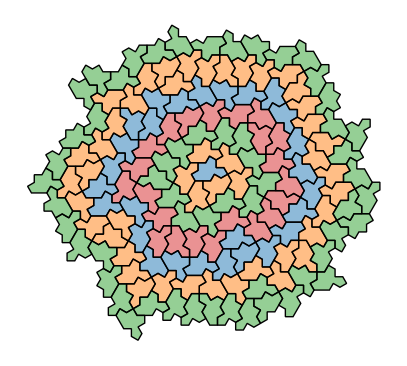

In [29]:
# Transform the hat tiling into a Tile(a,b) tiling

fig,ax = plt.subplots(figsize=(5, 5))
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
tiling_with_tiles = {}
for corona, hats in tiling7.items():
    colour = colours[corona % len(colours)]
    for i,hat in enumerate(hats):
        starting_index,prev_j,idx_prev = get_starting_index(hat,corona,tiling7)
        if corona >= 1:
            starting_vertex = tiling_with_tiles[corona-1][prev_j][idx_prev]
        else:
            starting_vertex = hat[0]
        tile = tile_ab(hat,starting_index,starting_vertex,1,1)
        tiling_with_tiles.setdefault(corona,[]).append(tile)
        draw_tile(ax,tile,colour=colour)
ax.set_aspect('equal', 'box')
ax.autoscale_view()
ax.axis('off')
# plt.savefig("tiling7.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Tile(1,1) to Spectre

In [30]:
from scipy.io import loadmat
data = loadmat('Bezier/bezier_curve.mat')
B = data['data']['B'][0,0]
xy = data['xy'] 

(-0.05, 1.05, -0.1625845468118954, 0.007742121276756925)

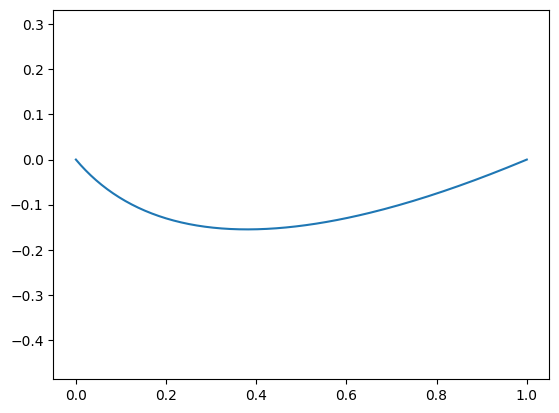

In [32]:
plt.plot(xy[:,0],xy[:,1])
plt.axis('equal')

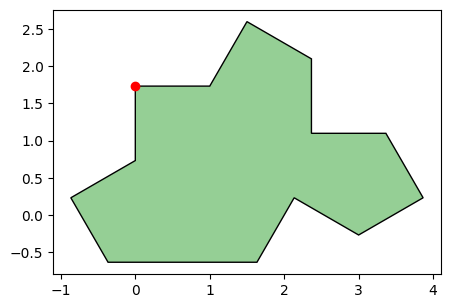

In [166]:
# draw tile11
fig,ax = plt.subplots(figsize=(5, 5))
draw_tile(ax,tile11,colour=colour)
ax.set_aspect('equal', 'box')
ax.autoscale_view()
# ax.axis('off')
plt.plot(tile11[0][0],tile11[0][1], 'ro') #starting point
plt.show()

In [35]:
def rotate_line(phi, line, starting_vertex):
    R = np.array([[math.cos(phi), -math.sin(phi)], [math.sin(phi), math.cos(phi)]])
    # translate line to origin
    line_t = line - line[-1]

    return (R @ line_t.T).T + starting_vertex

In [217]:
def angle_at_vertex(p_prev, p_curr, p_next):
    v1 = (p_prev[0] - p_curr[0], p_prev[1] - p_curr[1])
    v2 = (p_next[0] - p_curr[0], p_next[1] - p_curr[1])
    
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    det = v1[0]*v2[1] - v1[1]*v2[0]
    
    angle = math.atan2(det, dot)  # returns signed angle in radians
    if angle < 0:
        angle += 2*math.pi       # convert to 0..2pi range
    
    return angle

In [218]:
def polygon_angles(vertices):
    n = len(vertices)
    angles = []
    for i in range(n):
        p_prev = vertices[i-1]
        p_curr = vertices[i]
        p_next = vertices[(i+1) % n]
        angles.append(angle_at_vertex(p_prev, p_curr, p_next))
    return angles

In [303]:
def polygon_orientation(vertices):
    """
    Determine if a polygon is ordered clockwise (CW) or counterclockwise (CCW).

    Parameters
    ----------
    vertices : list of (x, y)
        Ordered list of polygon vertices.

    Returns
    -------
    str : 'CCW' or 'CW'
    """
    area = 0
    n = len(vertices)
    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += (x2 - x1) * (y2 + y1)
    return 'CCW' if area < 0 else 'CW'


In [352]:
def align_sequences(seq1, seq2, eps=1e-8):
    """
    Aligns two sequences of floats (angles in radians) that are rotations of each other.
    
    Returns:
        (rotation_index, direction)
        rotation_index: integer number of steps to rotate seq1 to match seq2
        direction: 'normal' if same orientation, 'reflected' if reversed
    """
    n = len(seq1)
    
    def is_close(a, b):
        return abs(a - b) < eps
    
    def match(s1, s2):
        return all(is_close(a, b) for a, b in zip(s1, s2))
    
    # Try normal orientation
    for i in range(n):
        rotated = seq1[i:] + seq1[:i]
        if match(rotated, seq2):
            return i
    
    # No match found
    return None

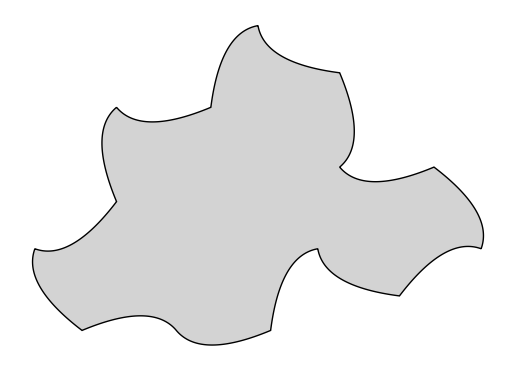

In [ ]:
# Plot one spectre (tile11 is the origin tile)

all_points = []
tile11_angles = [0, 4*math.pi/3,math.pi/2,2*math.pi/3,3*math.pi/2,2*math.pi/3,math.pi/2,2*math.pi/3,3*math.pi/2,2*math.pi/3,math.pi,2*math.pi/3,math.pi/2,4*math.pi/3,math.pi/2]

line = xy

for i in range(len(tile11)-1):
    x0, y0 = tile11[i]
    x1, y1 = tile11[i+1]
    angle = tile11_angles[i]
    
    if i % 2 == 1:
        line = rotate_line(angle, line, tile11[i])
    else:
        line = rotate_line(angle, line, tile11[i+1])
    # if i % 2 == 1:
    #     print(line[::-1][0],line[::-1][-1])
    # else:
    #     print(line[0],line[-1])

    if i > 0 and i % 2 == 1:
        l = line[::-1]
        l = l[1:]
    elif i > 0 and i % 2 == 0:
        l = line[1:]        
    else:
        l = line
        
    all_points.extend(l.tolist())

poly = Polygon(all_points, closed=True, facecolor='lightgray', edgecolor='black', linewidth=1)

fig, ax = plt.subplots()
ax.add_patch(poly)
ax.set_aspect('equal', 'box')
ax.autoscale_view()
plt.axis('off')
plt.savefig("spectre.pdf", format="pdf", bbox_inches="tight")

In [317]:
tile11

[(0.0, 1.7320508075688772),
 (1.0, 1.7320508075688772),
 (1.5, 2.598076211353316),
 (2.3660254037844384, 2.098076211353316),
 (2.3660254037844384, 1.098076211353316),
 (3.3660254037844384, 1.098076211353316),
 (3.8660254037844384, 0.23205080756887742),
 (2.9999999999999996, -0.26794919243112253),
 (2.1339745962155607, 0.23205080756887742),
 (1.6339745962155605, -0.6339745962155612),
 (0.6339745962155605, -0.6339745962155611),
 (-0.3660254037844395, -0.633974596215561),
 (-0.8660254037844397, 0.23205080756887764),
 (-9.992007221626409e-16, 0.7320508075688776),
 (0.0, 1.7320508075688772)]

In [355]:
# plot spectre tiling

inner_angles = [0, 4*math.pi/3,math.pi/2,2*math.pi/3,3*math.pi/2,2*math.pi/3,math.pi/2,2*math.pi/3,3*math.pi/2,2*math.pi/3,math.pi,2*math.pi/3,math.pi/2,4*math.pi/3,math.pi/2]
line = xy

def plot_spectre(tile,ax,line,colour):

    all_points = []
    # x0, y0 = tile[0]
    # x1, y1 = tile[1]
    # dx = x1 - x0
    # dy = y1 - y0
    # starting_angle = math.atan2(dy,dx)
    rotated_angles = [0] + polygon_angles(rotate_list(tile[:-1],1))
    i = align_sequences(rotated_angles[1:],inner_angles[1:])
    # tile = rotate_list(tile,i)

    starting_angle = angle_at_vertex(np.array(tile11[1]),np.array(tile11[0]),np.array(tile[1]) - np.array([tile[0][0] - tile11[0][0],tile[0][1] - tile11[0][1]]))
    line = rotate_line(starting_angle,line,xy[-1])

    for i in range(len(tile)-1):  
        angle = rotated_angles[i]      
        if i % 2 == 1:
            line = rotate_line(angle, line, tile[i])
        else:
            line = rotate_line(angle, line, tile[i+1])

        if i > 0 and i % 2 == 1:
            l = line[::-1]
            l = l[1:]
        elif i > 0 and i % 2 == 0:
            l = line[1:]        
        else:
            l = line

        all_points.extend(l.tolist())

    poly = Polygon(all_points, closed=True, facecolor=colour, edgecolor='black', linewidth=1)
    ax.add_patch(poly)

(-7.379795053274204, 9.358927223954627, -8.036974730246651, 9.212259323633706)

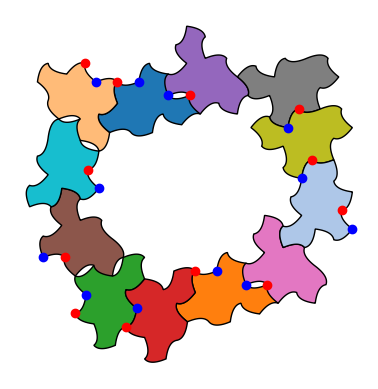

In [ ]:
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf",  # cyan
    "#aec7e8",  # light blue
    "#ffbb78",  # light orange
    "#98df8a",  # light green
    "#c5b0d5"   # light purple
]

fig, ax = plt.subplots()    

i = 0
for k,tiles in tiling_with_tiles.items():
    if k==2:
        for tile in tiles:
            if polygon_orientation(tile) == 'CCW':
                tile = tile[::-1]
            plot_spectre(tile,ax,line,colors[i])            
            i+=1

ax.set_aspect('equal', 'box')
ax.autoscale_view()
plt.axis('off')

In [320]:
tile11[0]

(0.0, 1.7320508075688772)

In [321]:
tile11[1]

(1.0, 1.7320508075688772)

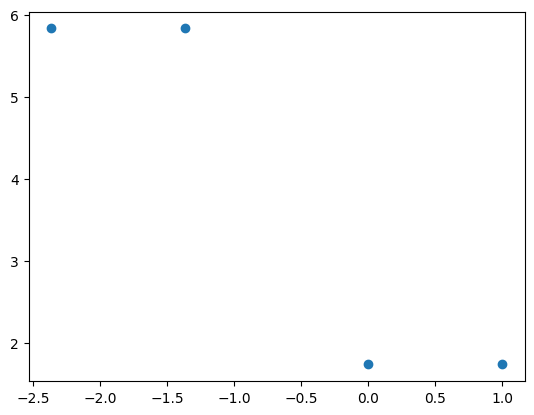

In [342]:
fig, ax = plt.subplots() 

plt.scatter([0,1,-2.3660254037844393,-1.3660254037844393],[1.7320508075688772,1.7320508075688772,5.830127018922193,5.830127018922193])

